In [12]:
using ProgressMeter
using JLD
using Random
include("../alpcahus.jl")
include("../helperFunctions.jl")
include("../cluster.jl")

hungarianAlgorithm (generic function with 1 method)

In [6]:
D = 50 # ambient space dimension
d = 3 # subspace dimension
goodPoints = 6 # good points per subspace
ν1 = 0.1 # noise variance good points
K = 2 # subspace count
varianceRatio = range( 1,300,5) # variance ratio for heatmaps
pointRatio = range(1,50,5) # point ratio between good bad data for heatmaps
trials = 100; # smoother results
qValue = 24;

In [5]:
seedVector1 = rand(Xoshiro(1234), 1:100000, trials*length(varianceRatio)*length(pointRatio));
seedVector2 = rand(Xoshiro(4321), 1:100000, trials*length(varianceRatio)*length(pointRatio));
seedVector3 = rand(Xoshiro(2143), 1:100000, trials*length(varianceRatio)*length(pointRatio));
seedVector4 = rand(Xoshiro(3412), 1:100000, trials*length(varianceRatio)*length(pointRatio));

In [6]:
# ν2 = 100*ν1
# badPoints = round(Int, 25*goodPoints)

# U1 = generateSubspace(goodPoints,badPoints,d,D);
# U2 = generateSubspace(goodPoints,badPoints,d,D);
# X1 = generateData(U1, ν1, ν2, goodPoints, badPoints, d, D)
# X2 = generateData(U2, ν1, ν2, goodPoints, badPoints, d, D)
# X = hcat(X1,X2);
# # cluster assignments
# C1 = vec([1*ones(size(X1)[2],1); 2*ones(size(X2)[2],1)]);
# C2 = vec([2*ones(size(X1)[2],1); 1*ones(size(X2)[2],1)]);


In [7]:
# TEST = ALPCAHUS(X,K, d; B=128,q=6,T=3,alpcahIter=10,pcaMethod=:alpcah, extraStep=true) #ALPCAHUS(X,128,3, K, d,:alpcah,10,6)#clusterError(estimatedCluster, C1, C2)
# clusterError(TEST, C1, C2)

In [9]:
ekssTensor = zeros(length(varianceRatio), length(pointRatio),trials)
alpcahTensor = zeros(length(varianceRatio), length(pointRatio),trials)
oracleTensor = zeros(length(varianceRatio), length(pointRatio),trials)

count = 1
@showprogress 1 "Running..." for i = 1:length(varianceRatio) # varianceRatio
     for j = 1:length(pointRatio) # prepend Threads.@threads for multi-threading
        for k = 1:trials
            # other parameters
            ν2 = varianceRatio[i]*ν1
            badPoints = round(Int, pointRatio[j]*goodPoints)
            # subspace generation
            U1 = generateSubspace(D, d; seed=seedVector1[count]) 
            U2 = generateSubspace(D, d; seed=seedVector2[count])
            # data generation
            X1 = generateData(U1, [ν1,ν2], [goodPoints,badPoints]; seed=seedVector3[count])
            X2 = generateData(U2, [ν1,ν2], [goodPoints,badPoints]; seed=seedVector4[count])
            # complete data matrix
            X = hcat(X1,X2);
            # cluster assignments
            C1 = vec([1*ones(size(X1)[2],1); 2*ones(size(X2)[2],1)]);
            C2 = vec([2*ones(size(X1)[2],1); 1*ones(size(X2)[2],1)]);
            # ekss trial
            estimatedCluster = ALPCAHUS(X,K, d; B=1, q=qValue, T=100, subspaceMethod=:pca, finalStep=false)
            ekssTensor[i,j,k] = clusterError(estimatedCluster, C1, C2)
            # alpcahus trail
            estimatedCluster = ALPCAHUS(X,K, d; B=1, q=qValue, T=100, alpcahIter=100, subspaceMethod=:alpcah, finalStep=true, varfloor=1e-9, varianceMethod=:groupless) 
            alpcahTensor[i,j,k] = clusterError(estimatedCluster, C1, C2)
            # noisy oracle trial       
            noisyU1 = svd(X1[:,1:goodPoints]).U[:,1:d]
            noisyU2 = svd(X2[:,1:goodPoints]).U[:,1:d]
            estimatedCluster = 1 .+ Vector{Int8}(norm.(eachcol(noisyU1'*X)) .> norm.(eachcol(noisyU2'*X)));
            oracleTensor[i,j,k] = clusterError(estimatedCluster, C1, C2)
            # increase count
            count = count + 1
        end
    end
end

save("kss/trialData.jld", "ekss", ekssTensor, "alpcah", alpcahTensor, "oracle", oracleTensor);

Running... 100%|█████████████████████████████████████████| Time: 1:15:05


In [3]:
trialData = load("trialData.jld")
ekssTensor = trialData["ekss"]
alpcahTensor = trialData["alpcah"]
oracleTensor = trialData["oracle"];

In [32]:
generateHeatmap(pointRatio, varianceRatio, ekssTensor; plotType=:median, methodType="KSS", ν1=ν1, goodPoints=goodPoints)
savefig("kss_median.pdf")

"/home/javier/Desktop/alpcahus/kss/kss_median.pdf"

In [33]:
generateHeatmap(pointRatio, varianceRatio, alpcahTensor; plotType=:median, methodType="ALPCAHUS", ν1=ν1, goodPoints=goodPoints)
savefig("alpcahus_median.pdf")

"/home/javier/Desktop/alpcahus/kss/alpcahus_median.pdf"

In [34]:
generateHeatmap(pointRatio, varianceRatio, oracleTensor; plotType=:median, methodType="Noisy Oracle", ν1=ν1, goodPoints=goodPoints)
savefig("oracle_median.pdf")

"/home/javier/Desktop/alpcahus/kss/oracle_median.pdf"

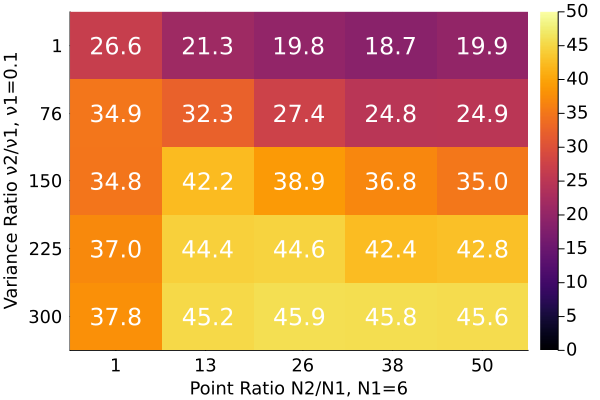

In [15]:
generateHeatmap(pointRatio, varianceRatio, ekssTensor; plotType=:mean, methodType="KSS", ν1=ν1, goodPoints=goodPoints)
#savefig("kss_mean.pdf")

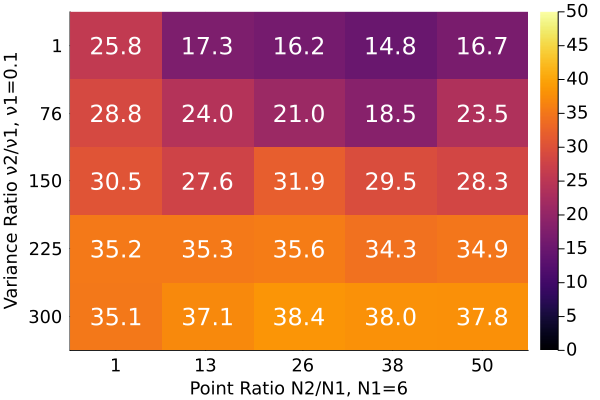

In [18]:
generateHeatmap(pointRatio, varianceRatio, alpcahTensor; plotType=:mean, methodType="ALPCAHUS", ν1=ν1, goodPoints=goodPoints)
#savefig("alpcahus_mean.pdf")

In [37]:
generateHeatmap(pointRatio, varianceRatio, oracleTensor; plotType=:mean, methodType="Noisy Oracle", ν1=ν1, goodPoints=goodPoints)
savefig("oracle_mean.pdf")

"/home/javier/Desktop/alpcahus/kss/oracle_mean.pdf"

In [38]:
generateHeatmap(pointRatio, varianceRatio, ekssTensor; plotType=:variance, methodType="KSS", ν1=ν1, goodPoints=goodPoints)
savefig("kss_variance.pdf")

"/home/javier/Desktop/alpcahus/kss/kss_variance.pdf"

In [39]:
generateHeatmap(pointRatio, varianceRatio, alpcahTensor; plotType=:variance, methodType="ALPCAHUS", ν1=ν1, goodPoints=goodPoints)
savefig("alpcahus_variance.pdf")

"/home/javier/Desktop/alpcahus/kss/alpcahus_variance.pdf"

In [40]:
generateHeatmap(pointRatio, varianceRatio, oracleTensor; plotType=:variance, methodType="Noisy Oracle", ν1=ν1, goodPoints=goodPoints)
savefig("oracle_variance.pdf")

"/home/javier/Desktop/alpcahus/kss/oracle_variance.pdf"